<center><h1>Image Classification of Waste Types via Transfer Learning</h1></center>

Name: Ashvanth Rathinavel
<br>
Github Username: Ashvanth11

In [66]:
import os, random, shutil, numpy as np, tensorflow as tf, matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50, resnet50, ResNet101, resnet, EfficientNetB0, efficientnet, VGG16, vgg16
from tensorflow.keras.layers import GlobalMaxPooling2D, Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, roc_auc_score
import warnings
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [4]:
warnings.filterwarnings('ignore')

## Dataset Splitting

In [6]:
random.seed(42)
SRC_DIR   = '../RealWaste'
OUT_DIR   = '../RealWaste_split'
TEST_FRAC = 0.20
VAL_FRAC  = 0.20

if os.path.exists(OUT_DIR):
    shutil.rmtree(OUT_DIR)

for cls in os.listdir(SRC_DIR):
    cls_src = os.path.join(SRC_DIR, cls)
    if not os.path.isdir(cls_src): continue

    imgs = sorted(os.listdir(cls_src))
    random.shuffle(imgs)

    n_total = len(imgs)
    n_test  = int(n_total * TEST_FRAC)
    n_rem   = n_total - n_test
    n_val   = int(n_rem * VAL_FRAC)

    test_imgs  = imgs[:n_test]
    val_imgs   = imgs[n_test:n_test + n_val]
    train_imgs = imgs[n_test + n_val:]

    for split_name, split_list in [
        ('train', train_imgs),
        ('val',   val_imgs),
        ('test',  test_imgs)
    ]:
        for fn in split_list:
            dst = os.path.join(OUT_DIR, split_name, cls)
            os.makedirs(dst, exist_ok=True)
            shutil.copy(os.path.join(cls_src, fn), os.path.join(dst, fn))

    print(f"{cls:20s} → train: {len(train_imgs):3d}, val: {len(val_imgs):3d}, test: {len(test_imgs):3d}")

print(f"\nSplitting complete. New folders under '{OUT_DIR}/'\n")

9-Vegetation         → train: 280, val:  69, test:  87
7-Plastic            → train: 590, val: 147, test: 184
1-Cardboard          → train: 296, val:  73, test:  92
6-Paper              → train: 320, val:  80, test: 100
5-Miscellaneous Trash → train: 317, val:  79, test:  99
8-Textile Trash      → train: 204, val:  51, test:  63
4-Metal              → train: 506, val: 126, test: 158
3-Glass              → train: 269, val:  67, test:  84
2-Food Organics      → train: 264, val:  65, test:  82

Splitting complete. New folders under '../RealWaste_split/'



## Data Preprocessing and Augmentation for ResNet50 and ResNet101

In [8]:
train_aug = ImageDataGenerator(
    preprocessing_function=resnet50.preprocess_input,
    rotation_range=20, width_shift_range=0.1, height_shift_range=0.1,
    zoom_range=0.2, horizontal_flip=True,
    brightness_range=(0.8,1.2), shear_range=0.2, channel_shift_range=0.1
)
plain_gen = ImageDataGenerator(preprocessing_function=resnet50.preprocess_input)

train_gen = train_aug.flow_from_directory(f'{OUT_DIR}/train', target_size=(224,224),
                                          batch_size=5, class_mode='categorical',
                                          shuffle=True, seed=42)
val_gen   = plain_gen.flow_from_directory(f'{OUT_DIR}/val',   target_size=(224,224),
                                          batch_size=5, class_mode='categorical',
                                          shuffle=False)
test_gen  = plain_gen.flow_from_directory(f'{OUT_DIR}/test',  target_size=(224,224),
                                          batch_size=5, class_mode='categorical',
                                          shuffle=False)

Found 3046 images belonging to 9 classes.
Found 757 images belonging to 9 classes.
Found 949 images belonging to 9 classes.


## ResNet50

In [10]:
base = ResNet50(weights='imagenet', include_top=False, input_shape=(224,224,3))
base.trainable = False

x = GlobalMaxPooling2D()(base.output)
x = Dense(256, kernel_regularizer=l2(1e-4), use_bias=False)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(0.2)(x)
out = Dense(9, activation='softmax', kernel_regularizer=l2(1e-4))(x)

model = Model(base.input, out)
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
              loss='categorical_crossentropy', metrics=['accuracy'])

2025-05-09 16:41:24.311542: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2025-05-09 16:41:24.311757: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-05-09 16:41:24.311774: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-05-09 16:41:24.312035: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-05-09 16:41:24.312060: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [12]:
callbacks = [
    EarlyStopping('val_loss', patience=20, restore_best_weights=True),
    ReduceLROnPlateau('val_loss', factor=0.5, patience=6, min_lr=1e-6, verbose=1),
    ModelCheckpoint('best_resnet50.keras', monitor='val_loss', save_best_only=True)
]

history = model.fit(train_gen, epochs=100, validation_data=val_gen,
                    callbacks=callbacks, verbose=2)

Epoch 1/100


2025-05-09 16:41:39.293751: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


610/610 - 52s - 85ms/step - accuracy: 0.4833 - loss: 1.5629 - val_accuracy: 0.6460 - val_loss: 1.0885 - learning_rate: 1.0000e-04
Epoch 2/100
610/610 - 40s - 66ms/step - accuracy: 0.6500 - loss: 1.0839 - val_accuracy: 0.7199 - val_loss: 0.8817 - learning_rate: 1.0000e-04
Epoch 3/100
610/610 - 44s - 73ms/step - accuracy: 0.6976 - loss: 0.9413 - val_accuracy: 0.7305 - val_loss: 0.8143 - learning_rate: 1.0000e-04
Epoch 4/100
610/610 - 55s - 90ms/step - accuracy: 0.7209 - loss: 0.8533 - val_accuracy: 0.7398 - val_loss: 0.7897 - learning_rate: 1.0000e-04
Epoch 5/100
610/610 - 52s - 86ms/step - accuracy: 0.7492 - loss: 0.7969 - val_accuracy: 0.7596 - val_loss: 0.7807 - learning_rate: 1.0000e-04
Epoch 6/100
610/610 - 52s - 85ms/step - accuracy: 0.7689 - loss: 0.7593 - val_accuracy: 0.7794 - val_loss: 0.6777 - learning_rate: 1.0000e-04
Epoch 7/100
610/610 - 53s - 87ms/step - accuracy: 0.7787 - loss: 0.7194 - val_accuracy: 0.7649 - val_loss: 0.7066 - learning_rate: 1.0000e-04
Epoch 8/100
610/61

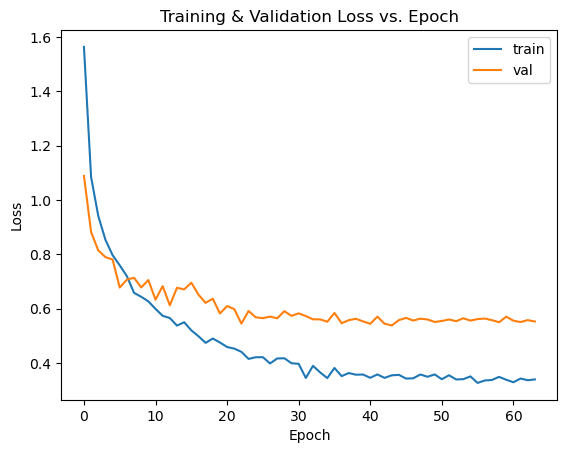

In [28]:
plt.plot(history.history['loss'], label='train') 
plt.plot(history.history['val_loss'], label='val')
plt.xlabel('Epoch') 
plt.ylabel('Loss') 
plt.legend()
plt.title('Training & Validation Loss vs. Epoch')
plt.show()

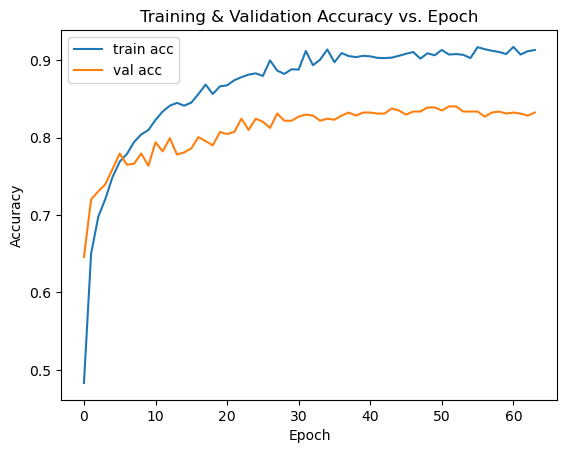

In [26]:
plt.plot(history.history['accuracy'],      label='train acc')
plt.plot(history.history['val_accuracy'],  label='val acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training & Validation Accuracy vs. Epoch')
plt.show()

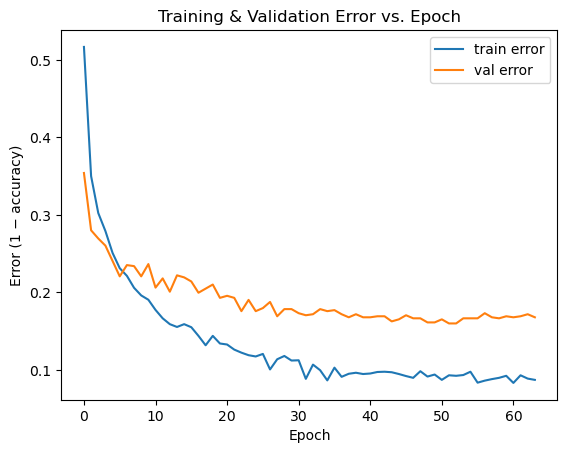

In [24]:
plt.plot(np.subtract(1, history.history['accuracy']),      label='train error')
plt.plot(np.subtract(1, history.history['val_accuracy']),  label='val error')
plt.xlabel('Epoch')
plt.ylabel('Error (1 − accuracy)')
plt.legend()
plt.title('Training & Validation Error vs. Epoch')
plt.show()

In [16]:
best = load_model('best_resnet50.keras')
loss, acc = best.evaluate(test_gen, verbose=0)
print(f"\nTest loss: {loss:.4f}  •  Test acc: {acc:.4f}")

probs = best.predict(test_gen)
preds = probs.argmax(1); true = test_gen.classes
print(classification_report(true, preds, target_names=test_gen.class_indices.keys()))
print("Macro‑AUC:", roc_auc_score(tf.keras.utils.to_categorical(true,9), probs,
                                  average='macro', multi_class='ovo').round(3))


Test loss: 0.5352  •  Test acc: 0.8409
190/190 ━━━━━━━━━━━━━━━━━━━━ 12s 55ms/step
                       precision    recall  f1-score   support

          1-Cardboard       0.76      0.92      0.83        92
      2-Food Organics       0.88      0.94      0.91        82
              3-Glass       0.78      0.82      0.80        84
              4-Metal       0.80      0.92      0.85       158
5-Miscellaneous Trash       0.84      0.72      0.77        99
              6-Paper       0.91      0.77      0.83       100
            7-Plastic       0.88      0.73      0.80       184
      8-Textile Trash       0.82      0.89      0.85        63
         9-Vegetation       0.97      0.95      0.96        87

             accuracy                           0.84       949
            macro avg       0.85      0.85      0.85       949
         weighted avg       0.85      0.84      0.84       949

Macro‑AUC: 0.985


## ResNet101

In [32]:
base = ResNet101(weights='imagenet', include_top=False, input_shape=(224,224,3))
base.trainable = False

x = GlobalMaxPooling2D()(base.output)
x = Dense(256, kernel_regularizer=l2(1e-4), use_bias=False)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(0.2)(x)
out = Dense(9, activation='softmax', kernel_regularizer=l2(1e-4))(x)

model = Model(base.input, out)
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

171446536/171446536 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [34]:
callbacks = [
    EarlyStopping('val_loss', patience=20, restore_best_weights=True),
    ReduceLROnPlateau('val_loss', factor=0.5, patience=6, min_lr=1e-6, verbose=1),
    ModelCheckpoint('best_resnet101.keras', monitor='val_loss', save_best_only=True)
]

In [36]:
history = model.fit(
    train_gen,
    epochs=100,
    validation_data=val_gen,
    callbacks=callbacks,
    verbose=2
)

Epoch 1/100
610/610 - 78s - 128ms/step - accuracy: 0.4688 - loss: 1.5601 - val_accuracy: 0.6328 - val_loss: 1.0532 - learning_rate: 1.0000e-04
Epoch 2/100
610/610 - 65s - 107ms/step - accuracy: 0.6504 - loss: 1.0559 - val_accuracy: 0.7081 - val_loss: 0.8682 - learning_rate: 1.0000e-04
Epoch 3/100
610/610 - 68s - 111ms/step - accuracy: 0.7055 - loss: 0.9163 - val_accuracy: 0.7464 - val_loss: 0.7822 - learning_rate: 1.0000e-04
Epoch 4/100
610/610 - 83s - 136ms/step - accuracy: 0.7209 - loss: 0.8744 - val_accuracy: 0.7411 - val_loss: 0.7723 - learning_rate: 1.0000e-04
Epoch 5/100
610/610 - 78s - 128ms/step - accuracy: 0.7538 - loss: 0.7899 - val_accuracy: 0.7450 - val_loss: 0.7851 - learning_rate: 1.0000e-04
Epoch 6/100
610/610 - 80s - 131ms/step - accuracy: 0.7603 - loss: 0.7497 - val_accuracy: 0.7622 - val_loss: 0.7551 - learning_rate: 1.0000e-04
Epoch 7/100
610/610 - 80s - 131ms/step - accuracy: 0.7692 - loss: 0.7423 - val_accuracy: 0.7635 - val_loss: 0.7136 - learning_rate: 1.0000e-04

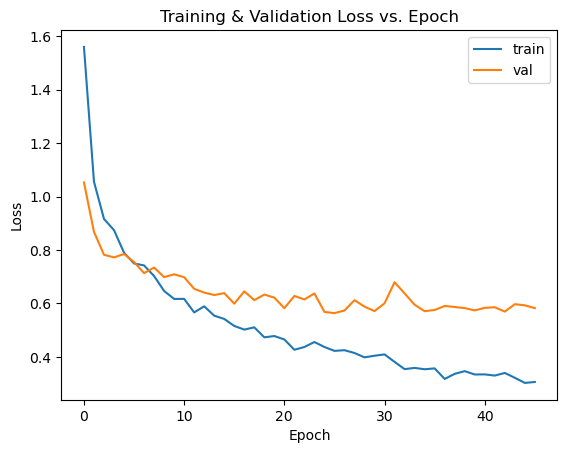

In [38]:
plt.plot(history.history['loss'], label='train') 
plt.plot(history.history['val_loss'], label='val')
plt.xlabel('Epoch') 
plt.ylabel('Loss') 
plt.legend()
plt.title('Training & Validation Loss vs. Epoch')
plt.show()

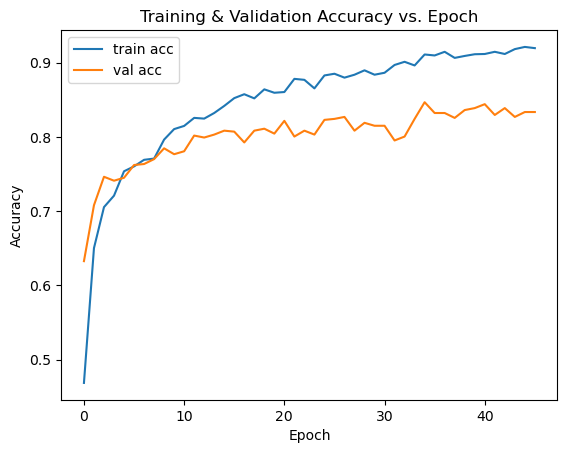

In [40]:
plt.plot(history.history['accuracy'],      label='train acc')
plt.plot(history.history['val_accuracy'],  label='val acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training & Validation Accuracy vs. Epoch')
plt.show()

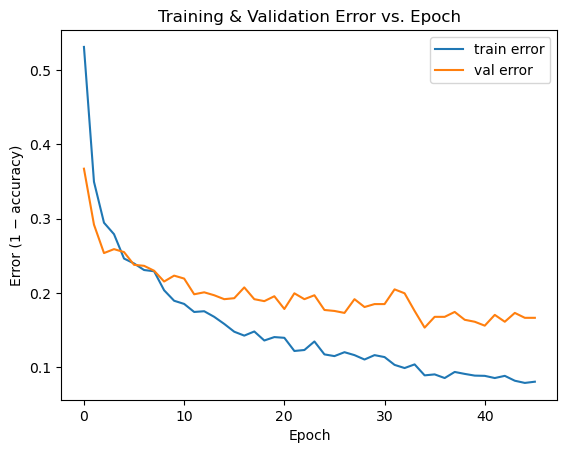

In [42]:
plt.plot(np.subtract(1, history.history['accuracy']),      label='train error')
plt.plot(np.subtract(1, history.history['val_accuracy']),  label='val error')
plt.xlabel('Epoch')
plt.ylabel('Error (1 − accuracy)')
plt.legend()
plt.title('Training & Validation Error vs. Epoch')
plt.show()

In [44]:
best = load_model('best_resnet101.keras')
loss, acc = best.evaluate(test_gen, verbose=0)
print(f"\nResNet‑101  •  Test loss: {loss:.4f}   Test acc: {acc:.4f}")

prob = best.predict(test_gen)
pred = prob.argmax(1); true = test_gen.classes
print(classification_report(true, pred, target_names=test_gen.class_indices.keys()))
print("Macro‑AUC:", roc_auc_score(tf.keras.utils.to_categorical(true,9), prob,
                                  average='macro', multi_class='ovo').round(3))


ResNet‑101  •  Test loss: 0.5549   Test acc: 0.8377
190/190 ━━━━━━━━━━━━━━━━━━━━ 23s 98ms/step
                       precision    recall  f1-score   support

          1-Cardboard       0.85      0.88      0.87        92
      2-Food Organics       0.87      0.84      0.86        82
              3-Glass       0.82      0.85      0.83        84
              4-Metal       0.75      0.91      0.82       158
5-Miscellaneous Trash       0.76      0.68      0.72        99
              6-Paper       0.92      0.83      0.87       100
            7-Plastic       0.86      0.78      0.82       184
      8-Textile Trash       0.87      0.84      0.85        63
         9-Vegetation       0.93      0.97      0.95        87

             accuracy                           0.84       949
            macro avg       0.85      0.84      0.84       949
         weighted avg       0.84      0.84      0.84       949

Macro‑AUC: 0.983


## Data Preprocessing and Augmentation for EfficientNetB0

In [48]:
BASE_DIR = '../RealWaste_split'
train_dir, val_dir, test_dir = [os.path.join(BASE_DIR, x) for x in ['train','val','test']]

In [50]:
train_aug = ImageDataGenerator(
    preprocessing_function=efficientnet.preprocess_input,
    rotation_range=20, width_shift_range=0.1, height_shift_range=0.1,
    zoom_range=0.2, horizontal_flip=True,
    brightness_range=(0.8,1.2), shear_range=0.2, channel_shift_range=0.1
)
plain_gen = ImageDataGenerator(preprocessing_function=efficientnet.preprocess_input)

train_gen = train_aug.flow_from_directory(train_dir, target_size=(224,224),
                                          batch_size=5, class_mode='categorical',
                                          shuffle=True, seed=42)
val_gen   = plain_gen.flow_from_directory(val_dir, target_size=(224,224),
                                          batch_size=5, class_mode='categorical',
                                          shuffle=False)
test_gen  = plain_gen.flow_from_directory(test_dir, target_size=(224,224),
                                          batch_size=5, class_mode='categorical',
                                          shuffle=False)

Found 3046 images belonging to 9 classes.
Found 757 images belonging to 9 classes.
Found 949 images belonging to 9 classes.


## EfficientNetB0

In [52]:
base = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224,224,3))
base.trainable = False

x = GlobalMaxPooling2D()(base.output)
x = Dense(256, kernel_regularizer=l2(1e-4), use_bias=False)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(0.2)(x)
out = Dense(9, activation='softmax', kernel_regularizer=l2(1e-4))(x)

model = Model(base.input, out)
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [54]:
callbacks = [
    EarlyStopping('val_loss', patience=20, restore_best_weights=True),
    ReduceLROnPlateau('val_loss', factor=0.5, patience=6, min_lr=1e-6, verbose=1),
    ModelCheckpoint('best_efficientnetb0.keras', monitor='val_loss', save_best_only=True)
]

In [56]:
history = model.fit(train_gen,
                    validation_data=val_gen,
                    epochs=100,
                    callbacks=callbacks,
                    verbose=2)


Epoch 1/100
610/610 - 46s - 76ms/step - accuracy: 0.4242 - loss: 1.7407 - val_accuracy: 0.6169 - val_loss: 1.1193 - learning_rate: 1.0000e-04
Epoch 2/100
610/610 - 32s - 52ms/step - accuracy: 0.6185 - loss: 1.1866 - val_accuracy: 0.6592 - val_loss: 1.0106 - learning_rate: 1.0000e-04
Epoch 3/100
610/610 - 32s - 52ms/step - accuracy: 0.6451 - loss: 1.0782 - val_accuracy: 0.7015 - val_loss: 0.9210 - learning_rate: 1.0000e-04
Epoch 4/100
610/610 - 32s - 53ms/step - accuracy: 0.6852 - loss: 0.9650 - val_accuracy: 0.7160 - val_loss: 0.8672 - learning_rate: 1.0000e-04
Epoch 5/100
610/610 - 34s - 55ms/step - accuracy: 0.7081 - loss: 0.9074 - val_accuracy: 0.7266 - val_loss: 0.8248 - learning_rate: 1.0000e-04
Epoch 6/100
610/610 - 35s - 58ms/step - accuracy: 0.7255 - loss: 0.8704 - val_accuracy: 0.7517 - val_loss: 0.7625 - learning_rate: 1.0000e-04
Epoch 7/100
610/610 - 37s - 60ms/step - accuracy: 0.7397 - loss: 0.8446 - val_accuracy: 0.7530 - val_loss: 0.7515 - learning_rate: 1.0000e-04
Epoch 

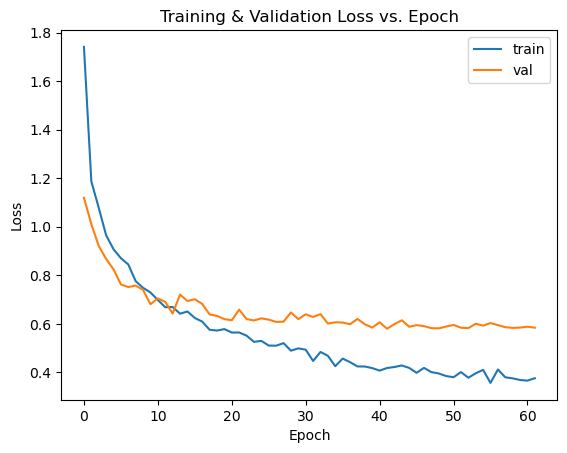

In [58]:
plt.plot(history.history['loss'], label='train') 
plt.plot(history.history['val_loss'], label='val')
plt.xlabel('Epoch') 
plt.ylabel('Loss') 
plt.legend()
plt.title('Training & Validation Loss vs. Epoch')
plt.show()

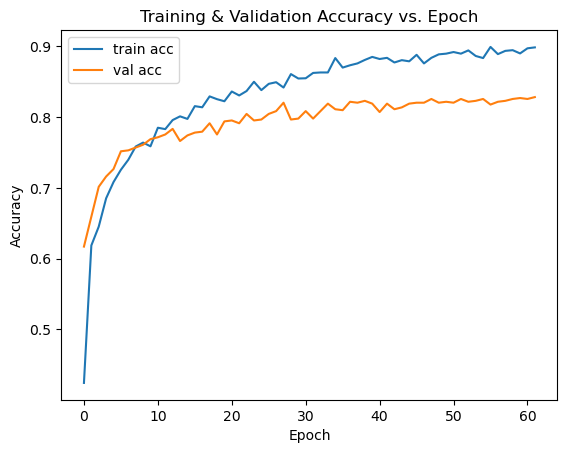

In [60]:
plt.plot(history.history['accuracy'],      label='train acc')
plt.plot(history.history['val_accuracy'],  label='val acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training & Validation Accuracy vs. Epoch')
plt.show()

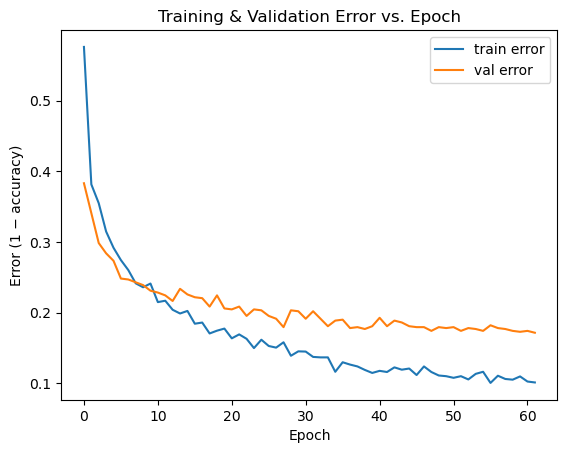

In [62]:
plt.plot(np.subtract(1, history.history['accuracy']),      label='train error')
plt.plot(np.subtract(1, history.history['val_accuracy']),  label='val error')
plt.xlabel('Epoch')
plt.ylabel('Error (1 − accuracy)')
plt.legend()
plt.title('Training & Validation Error vs. Epoch')
plt.show()

In [64]:
best = load_model('best_efficientnetb0.keras')
loss, acc = best.evaluate(test_gen, verbose=0)
print(f"\nEfficientNetB0  •  Test loss: {loss:.4f}   Test acc: {acc:.4f}")

prob = best.predict(test_gen)
pred = prob.argmax(1); true = test_gen.classes
print(classification_report(true, pred, target_names=test_gen.class_indices.keys()))
print("Macro‑AUC:", roc_auc_score(tf.keras.utils.to_categorical(true,9), prob,
                                  average='macro', multi_class='ovo').round(3))


EfficientNetB0  •  Test loss: 0.6103   Test acc: 0.8314
190/190 ━━━━━━━━━━━━━━━━━━━━ 12s 47ms/step
                       precision    recall  f1-score   support

          1-Cardboard       0.68      0.90      0.78        92
      2-Food Organics       0.88      0.83      0.86        82
              3-Glass       0.82      0.87      0.84        84
              4-Metal       0.84      0.85      0.85       158
5-Miscellaneous Trash       0.74      0.64      0.68        99
              6-Paper       0.92      0.80      0.86       100
            7-Plastic       0.85      0.81      0.83       184
      8-Textile Trash       0.89      0.87      0.88        63
         9-Vegetation       0.91      0.95      0.93        87

             accuracy                           0.83       949
            macro avg       0.84      0.84      0.83       949
         weighted avg       0.84      0.83      0.83       949

Macro‑AUC: 0.981


## Data Preprocessing and Augmentation for VGG16

In [68]:
BASE_DIR = '../RealWaste_split'
train_dir, val_dir, test_dir = [os.path.join(BASE_DIR, x) for x in ['train','val','test']]

In [70]:
train_aug = ImageDataGenerator(
    preprocessing_function=vgg16.preprocess_input,
    rotation_range=20, width_shift_range=0.1, height_shift_range=0.1,
    zoom_range=0.2, horizontal_flip=True,
    brightness_range=(0.8,1.2), shear_range=0.2, channel_shift_range=0.1
)
plain_gen = ImageDataGenerator(preprocessing_function=vgg16.preprocess_input)

train_gen = train_aug.flow_from_directory(
    train_dir, target_size=(224,224), batch_size=5, class_mode='categorical',
    shuffle=True, seed=42
)
val_gen   = plain_gen.flow_from_directory(
    val_dir, target_size=(224,224), batch_size=5, class_mode='categorical',
    shuffle=False
)
test_gen  = plain_gen.flow_from_directory(
    test_dir, target_size=(224,224), batch_size=5, class_mode='categorical',
    shuffle=False
)

Found 3046 images belonging to 9 classes.
Found 757 images belonging to 9 classes.
Found 949 images belonging to 9 classes.


## VGG16

In [74]:
base = VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3))
base.trainable = False

x = GlobalMaxPooling2D()(base.output)         
x = Dense(256, kernel_regularizer=l2(1e-4), use_bias=False)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(0.2)(x)
out = Dense(9, activation='softmax', kernel_regularizer=l2(1e-4))(x)

model = Model(base.input, out)
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [76]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True),
    ReduceLROnPlateau('val_loss', factor=0.5, patience=6, min_lr=1e-6, verbose=1),
    ModelCheckpoint('best_vgg16.keras', monitor='val_loss', save_best_only=True)
]

In [78]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=100,
    callbacks=callbacks,
    verbose=2
)

Epoch 1/100
610/610 - 54s - 88ms/step - accuracy: 0.3001 - loss: 2.0034 - val_accuracy: 0.4531 - val_loss: 1.4972 - learning_rate: 1.0000e-04
Epoch 2/100
610/610 - 52s - 85ms/step - accuracy: 0.4806 - loss: 1.5251 - val_accuracy: 0.5443 - val_loss: 1.3031 - learning_rate: 1.0000e-04
Epoch 3/100
610/610 - 59s - 97ms/step - accuracy: 0.5387 - loss: 1.3462 - val_accuracy: 0.6063 - val_loss: 1.1114 - learning_rate: 1.0000e-04
Epoch 4/100
610/610 - 78s - 128ms/step - accuracy: 0.5939 - loss: 1.2094 - val_accuracy: 0.6354 - val_loss: 1.0634 - learning_rate: 1.0000e-04
Epoch 5/100
610/610 - 75s - 122ms/step - accuracy: 0.6011 - loss: 1.1888 - val_accuracy: 0.6631 - val_loss: 0.9911 - learning_rate: 1.0000e-04
Epoch 6/100
610/610 - 74s - 122ms/step - accuracy: 0.6238 - loss: 1.1077 - val_accuracy: 0.6724 - val_loss: 0.9747 - learning_rate: 1.0000e-04
Epoch 7/100
610/610 - 74s - 122ms/step - accuracy: 0.6458 - loss: 1.0619 - val_accuracy: 0.6764 - val_loss: 0.9314 - learning_rate: 1.0000e-04
Ep

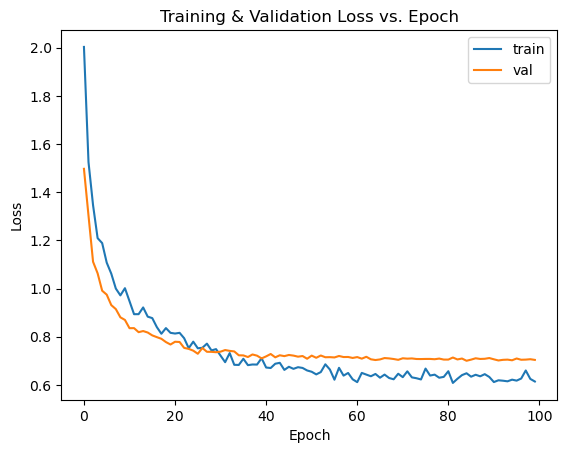

In [80]:
plt.plot(history.history['loss'], label='train') 
plt.plot(history.history['val_loss'], label='val')
plt.xlabel('Epoch') 
plt.ylabel('Loss') 
plt.legend()
plt.title('Training & Validation Loss vs. Epoch')
plt.show()

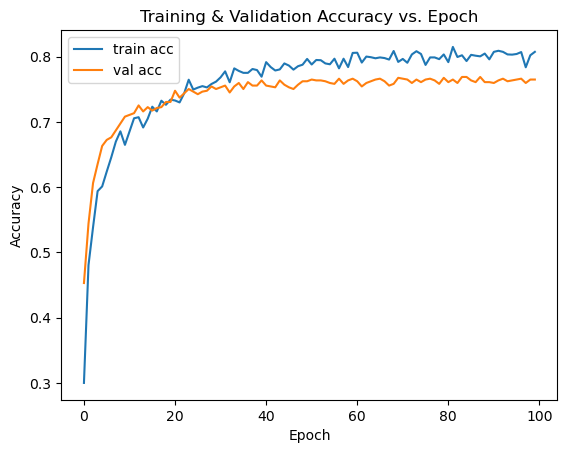

In [82]:
plt.plot(history.history['accuracy'],      label='train acc')
plt.plot(history.history['val_accuracy'],  label='val acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training & Validation Accuracy vs. Epoch')
plt.show()

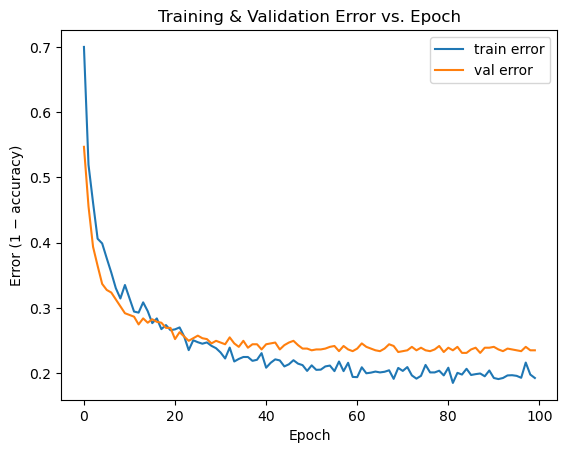

In [84]:
plt.plot(np.subtract(1, history.history['accuracy']),      label='train error')
plt.plot(np.subtract(1, history.history['val_accuracy']),  label='val error')
plt.xlabel('Epoch')
plt.ylabel('Error (1 − accuracy)')
plt.legend()
plt.title('Training & Validation Error vs. Epoch')
plt.show()

In [86]:
best = load_model('best_vgg16.keras')
loss, acc = best.evaluate(test_gen, verbose=0)
print(f"\nVGG 16  •  Test loss: {loss:.4f}   Test acc: {acc:.4f}")

prob = best.predict(test_gen)
pred = prob.argmax(1); true = test_gen.classes
print(classification_report(true, pred, target_names=test_gen.class_indices.keys()))
print("Macro‑AUC:", roc_auc_score(tf.keras.utils.to_categorical(true,9), prob,
                                  average='macro', multi_class='ovo').round(3))


VGG 16  •  Test loss: 0.6903   Test acc: 0.7745
190/190 ━━━━━━━━━━━━━━━━━━━━ 12s 61ms/step
                       precision    recall  f1-score   support

          1-Cardboard       0.69      0.83      0.75        92
      2-Food Organics       0.75      0.94      0.83        82
              3-Glass       0.78      0.79      0.78        84
              4-Metal       0.76      0.79      0.78       158
5-Miscellaneous Trash       0.65      0.47      0.55        99
              6-Paper       0.82      0.76      0.79       100
            7-Plastic       0.79      0.75      0.77       184
      8-Textile Trash       0.82      0.81      0.82        63
         9-Vegetation       0.93      0.91      0.92        87

             accuracy                           0.77       949
            macro avg       0.78      0.78      0.78       949
         weighted avg       0.77      0.77      0.77       949

Macro‑AUC: 0.972


## Conclusion

In this project, we evaluated the performance of four pre-trained deep learning models—ResNet‑50, ResNet‑101, EfficientNetB0, and VGG16—as frozen feature extractors for a multi-class waste classification task. Each model was paired with a compact fully connected head (ReLU + Softmax, L2 regularization, Batch Normalization, and Dropout) and trained using only the outputs of the frozen base. <br>
ResNet‑50 outperformed the others, achieving the highest test accuracy (0.84), macro F1 score (0.85), and macro AUC (0.985), while maintaining balanced performance across all nine waste classes. While ResNet‑101 and EfficientNetB0 produced competitive results with 0.83 test accuracy, they did not surpass ResNet‑50. VGG16 showed the weakest generalization on this task with a test accuracy of 0.77.